In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import numpy as np
from typing import List, Tuple, Optional
from torch.optim import Adam, AdamW, Adamax, SGD
import torch.optim as optim

device='cuda' if torch.cuda.is_available() else 'cpu'

import torch
def similarity_matrix(x):
    ''' Calculate adjusted cosine similarity matrix of size x.size(0) x x.size(0). '''
    if x.dim() == 4:
        x = x.view(x.size(0),-1)
    xc = x - x.mean(dim=1).unsqueeze(1)
    xn = xc / (1e-8 + torch.sqrt(torch.sum(xc**2, dim=1))).unsqueeze(1)
    R = xn.matmul(xn.transpose(1,0)).clamp(-1,1)
    return R

def L_per(q: torch.Tensor, p: torch.Tensor,
                      reduction: str = "mean",
                      eps: float = 1e-12,
                      detach_p: bool = True) -> torch.Tensor:
    """
    q, p: [B, K] probabilities (nonnegative; rows ~ sum to 1).
    """
    if detach_p:
        p = p.detach()
    q = (q.clamp_min(eps) / q.clamp_min(eps).sum(dim=-1, keepdim=True))
    p = (p.clamp_min(eps) / p.clamp_min(eps).sum(dim=-1, keepdim=True))
    # log BC via log-sum-exp for stability
    log_bc = torch.logsumexp(0.5 * (q.log() + p.log()), dim=-1)
    loss_per = -log_bc
    return (loss_per.mean() if reduction == "mean"
            else loss_per.sum() if reduction == "sum"
            else loss_per)

class VGG11(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        num_classes: int = 100,
        lr: float = 0.001,
    ):
        super().__init__()
        
        self.num_classes = num_classes
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = 1
        
        # self.conv_configs = [
        #     (in_channels, 64),    # Conv1 - pool
        #     (64, 128),           # Conv2 - pool
        #     (128, 256),          # Conv3
        #     (256, 256),          # Conv4 - pool
        #     (256, 512),          # Conv5
        #     (512, 512),          # Conv6 - pool
        #     (512, 512),          # Conv7
        #     (512, 512),          # Conv8 - pool
        # ]
        
        # self.conv_configs = [
        #     (in_channels, 256),    # Conv1 - pool
        #     (256, 256),           # Conv2 - pool
        #     (256, 512),          # Conv3
        #     (512, 512),          # Conv4 - pool
        #     (512, 1024),          # Conv5
        #     (1024, 1024),          # Conv6 - pool
        #     (1024, 1024),          # Conv7
        #     (1024, 1024),          # Conv8 - pool
        # ]
        
        self.conv_configs = [
            (in_channels, 256),    # Conv1 - pool
            (256, 512),           # Conv2 - pool
            (512, 512),          # Conv3
            (512, 1024),          # Conv4 - pool
            (1024, 1024),          # Conv5
            (1024, 1024),          # Conv6 - pool
            (1024, 1024),          # Conv7
            (1024, 1024),          # Conv8 - pool
        ]
        
        self.conv_layers = nn.ModuleList()
        self.conv_norms = nn.ModuleList() 
        self.conv_beta = nn.ParameterList() 
        
        self.conv_optimizers = []
        self.conv_param_layer = []
        
        current_size = 32
        for i, (in_ch, out_ch) in enumerate(self.conv_configs):
            conv_i = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            # bn_i = nn.LayerNorm([out_ch, current_size, current_size])
            bn_i = nn.BatchNorm2d(out_ch)
            self.conv_layers.append(conv_i)
            self.conv_norms.append(bn_i)
            if i in [0, 1, 3, 5, 7]:
                current_size = current_size // 2
                
            selected_params = list(conv_i.parameters())
            selected_params += list(bn_i.parameters())
            self.conv_optimizers.append(Adam(selected_params,lr = lr,eps=1e-8, betas=(.9, .999)))
            # self.conv_optimizers.append(optim.SGD(selected_params, lr=0.01, momentum=0.9, weight_decay=1e-4))
            self.conv_param_layer.append(selected_params)
            
        # Learning rate scheduler
        # self.scheduler = None
        # self.scheduler = optim.lr_scheduler.StepLR(self.conv_optimizers[0], step_size=100, gamma=0.2) 
        # self.scheduler = optim.lr_scheduler.MultiStepLR(self.conv_optimizers[0], milestones=[60, 150, 200], gamma=0.3)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.conv_optimizers[0], T_max=300, eta_min=1e-5)

        final_spatial_size = current_size
        self.feature_size = 1024
        
        self.fc_configs = [
            (self.feature_size, 4096),
            (4096, num_classes)
        ]
        # self.fc_configs = [
        #     (self.feature_size, num_classes)
        # ]
        
        self.fc_layers = nn.ModuleList()
        self.fc_norms = nn.ModuleList()
        self.fc_optimizers = []
        self.fc_param_layer = []
        
        for i, (in_features, out_features) in enumerate(self.fc_configs):
            layer_i = nn.Linear(in_features, out_features)
            self.fc_layers.append(layer_i)
            if i < len(self.fc_configs) - 1:
                bn_i = nn.BatchNorm1d(out_features)
                self.fc_norms.append(bn_i)
            else:
                bn_i = nn.LayerNorm(out_features)
                self.fc_norms.append(bn_i)
            selected_params = list(layer_i.parameters())
            selected_params += list(bn_i.parameters())
            self.fc_optimizers.append(Adam(selected_params,lr = lr,eps=1e-8, betas=(.9, .999)))
            # self.fc_optimizers.append(optim.SGD(selected_params, lr=0.01, momentum=0.9, weight_decay=1e-4))
            self.fc_param_layer.append(selected_params)
            
        self.optimizers = self.fc_optimizers + self.conv_optimizers
        self._init_weights()
        
        self.out_features = 1024
        self.conv_projections = []
        input_size = 32
        for i, layer in enumerate(self.conv_layers):
            out_channels = layer.out_channels
            if i in [0, 1, 3, 5, 7]:  # Layers with pooling
                input_size = input_size // 2
            feat_size = out_channels * input_size * input_size
            proj_dim = self.compute_dim_proj(feat_size)+self.num_classes
            R = torch.randn(proj_dim, self.num_classes).to(self.device) / np.sqrt(proj_dim)
            self.conv_projections.append(R)
        
        self.fc_projections = []
        for layer in self.fc_layers[:-1]:
            R = torch.randn(layer.out_features+self.num_classes, self.num_classes).to(self.device) / np.sqrt(layer.out_features)
            self.fc_projections.append(R)
        
        
        
    def compute_conv_drift(self, features, targets, pre_feat,layer_idx: int):
        """Compute supervised drift for initial conv layer"""
        tg_onehote = F.one_hot(targets, num_classes=self.num_classes).float()
        batch_size, channels, height, width = features.shape
        flattened = features.view(batch_size, -1)
        flattened = F.adaptive_avg_pool1d(flattened, self.conv_projections[layer_idx].shape[0]-self.num_classes)
        flattened = torch.cat([flattened, tg_onehote], dim=1)
        # flattened = F.adaptive_max_pool1d(flattened, self.conv_projections[layer_idx].shape[0])
        logits = flattened @ F.dropout(self.conv_projections[layer_idx], p=0.1)
        ce_loss  = F.cross_entropy(logits, targets,label_smoothing=0.)
        if pre_feat is not None:
            # sim_loss = F.mse_loss(similarity_matrix(logits), similarity_matrix(pre_feat.detach()))
            # sim_loss = .5*F.mse_loss(similarity_matrix(logits), similarity_matrix(pre_feat.detach())) + .5*F.mse_loss(logits,pre_feat.detach())
            sim_loss = L_per(F.softmax(logits,dim=-1),pre_feat.detach())+ .5*F.mse_loss(logits,pre_feat.detach())
            # sim_loss = F.mse_loss(similarity_matrix(logits), similarity_matrix(tg_onehote))
        else:
            # sim_loss = F.mse_loss(similarity_matrix(logits), similarity_matrix(tg_onehote))
            sim_loss = L_per(F.softmax(logits,dim=-1),tg_onehote)
            # sim_loss = .5*F.mse_loss(similarity_matrix(logits), similarity_matrix(tg_onehote)) + .5*F.mse_loss(logits,tg_onehote.detach())
    
        loss = 0.3*ce_loss + 0.7* sim_loss
        grad = torch.autograd.grad(loss, features, retain_graph=True)[0]
        return grad, F.softmax(logits, dim=1)
        # return grad, logits
        
    def compute_fc_drift(self, activations: torch.Tensor, targets: torch.Tensor, pre_feat: torch.Tensor,
                                 layer_idx: int) -> torch.Tensor:
        tg_onehote = F.one_hot(targets, num_classes=self.num_classes).float()
        sup_act = torch.cat((activations, tg_onehote), dim=1)
        # sup_act = activations
        layer_output = torch.matmul(sup_act, F.dropout(self.fc_projections[layer_idx],.1))
        # add the feature aligment loss
        if pre_feat is not None:
            ce_loss = F.cross_entropy(layer_output, targets, label_smoothing=0.) 
            sim_loss = F.mse_loss(similarity_matrix(layer_output), similarity_matrix(pre_feat.detach()))
        else:
            ce_loss = F.cross_entropy(layer_output, targets)
            sim_loss = F.mse_loss(similarity_matrix(layer_output), similarity_matrix(tg_onehote))
        
        loss = 0.2*ce_loss + 0.8* sim_loss
        grad = torch.autograd.grad(loss, activations, retain_graph=False)[0]
        return grad, F.softmax(layer_output, dim=1)
    
    def forward_with_update(self, x: torch.Tensor,y: torch.Tensor):
        # zero_grad all optimizers
        self.opts_zero_grad()
        pre_Rproj = None
        
        h = x
        
        for i, (conv, norm) in enumerate(zip(self.conv_layers, self.conv_norms)):
            h = h.detach()
            h = conv(h)
            h = norm(h)
            h = F.relu(h)
            if i in [0, 1, 3, 5, 7]:
                h = F.max_pool2d(h, 2)
            # update the layer
            supervised_drift,pre_Rproj = self.compute_conv_drift(h,y,pre_Rproj,i)
            h.backward(supervised_drift*self.alpha)
            # torch.nn.utils.clip_grad_norm_(self.conv_param_layer[i], max_norm=1.0)
            self.conv_optimizers[i].step()
        
        # h = F.adaptive_avg_pool2d(h, (1, 1))
        h = h.view(h.size(0), -1)
        
        for i, fc in enumerate(self.fc_layers[:-1]):
            h = h.detach()
            h = fc(h)
            if i < len(self.fc_norms):
                h = self.fc_norms[i](h)
            h = F.relu(h)
            h = F.dropout(h, p=0.5, training=self.training)
            # update the layer
            supervised_drift,pre_Rproj = self.compute_fc_drift(
                h,y,pre_Rproj,i)
            h.backward(supervised_drift*self.alpha)
            # torch.nn.utils.clip_grad_norm_(self.fc_param_layer[i], max_norm=1.0)
            self.fc_optimizers[i].step()

        h = h.detach()
        h = self.fc_norms[-1](self.fc_layers[-1](h))
        loss = F.cross_entropy(h, y) + L_per(F.softmax(h, dim=-1), pre_Rproj)
        # + F.mse_loss(similarity_matrix(h), similarity_matrix(pre_Rproj.detach()))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.fc_param_layer[-1], max_norm=1.0)
        self.fc_optimizers[-1].step()
        
        return h, loss.item()
    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = x
        
        for i, (conv, norm) in enumerate(zip(self.conv_layers, self.conv_norms)):
            h = conv(h)
            h = norm(h)
            h = F.relu(h)
            if i in [0, 1, 3, 5, 7]:
                h = F.max_pool2d(h, 2)
                
        # h = F.adaptive_avg_pool2d(h, (1, 1))
        h = h.view(h.size(0), -1)
        
        for i, fc in enumerate(self.fc_layers[:-1]):
            h = fc(h)
            if i < len(self.fc_norms):
                h = self.fc_norms[i](h)
            h = F.relu(h)
            h = F.dropout(h, p=0.5, training=self.training)
        
        return self.fc_norms[-1](self.fc_layers[-1](h))

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                
    def opts_zero_grad(self):
        for opt_l in self.conv_optimizers+self.fc_optimizers:
            opt_l.zero_grad()
    def id_zero_grad(self,i):
        self.optimizers[i].zero_grad()
    def compute_dim_proj(self, in_dim: int) -> int:
        eps = 0.1
        min_dim = int(4 * np.log(in_dim) / (eps**2/2 - eps**3/3))
        return min(in_dim, max(min_dim, 2048))
    
    def update_lr(self):
        lr = self.scheduler.get_last_lr()[0]  # Get the updated LR from the scheduler
        for opt_i in self.optimizers:
            for param_group in opt_i.param_groups:
                param_group['lr'] = lr
                
                

def train_cifar10(
    n_epochs=100,
    batch_size=64,
    learning_rate=0.001,
    hidden_sizes=[1024, 256],
    save_model=True
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    # mean_p = torch.tensor([0.5070751592371323, 0.48654887331495095, 0.4409178433670343], dtype=torch.float32)
    # std_p = torch.tensor([0.2673342858792401, 0.2564384629170883, 0.27615047132568404], dtype=torch.float32)
    mean_p = torch.tensor([0.49154913, 0.4821251, 0.44642678], dtype=torch.float32)
    std_p = torch.tensor([0.24703223, 0.24348513, 0.26158784], dtype=torch.float32)
    from ADL.aug_cifar10_policy import CIFAR10Policy
    train_transform = transforms.Compose([
            transforms.RandomCrop(size=(32, 32), padding=4),
            transforms.RandomHorizontalFlip(),
            # transforms.RandomRotation(15),
            CIFAR10Policy(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_p, std=std_p)
        ])
    # train_transform.transforms.append(Cutout(n_holes=args.n_holes, length=args.length)) 
    test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_p, std=std_p)
        ])

    train_dataset = datasets.CIFAR100(root='./data/cifar/', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR100(root='./data/cifar/', train=False, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model and optimizer
    model = VGG11(lr=learning_rate).to(device)

    # Training history
    history = defaultdict(list)
    best_accuracy = 0.66

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        n_batches = 0
        correct = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            output,loss = model.forward_with_update(data, target)

            epoch_loss += loss
            n_batches += 1
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / len(train_loader.dataset)

            pbar.set_postfix({
                'loss': f'{loss:.4f}','acc': f'{accuracy:.4f}',})
        if model.scheduler is not None:
            model.scheduler.step()
            model.update_lr()
        # if epoch % 100 ==0  and epoch>1:
        #     model.alpha = model.alpha*.75

        # Evaluate
        avg_train_loss = epoch_loss / n_batches
        test_loss, test_accuracy = evaluate_model(model, test_loader, device)


        # Store history
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_accuracy)

        # # Save best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            if save_model:
                torch.save(model.state_dict(), 'c100_vgg11x2bz-'+str(best_accuracy)+'.pth')
        if epoch % 10 == 0:
            # print(f'Epoch {epoch+1}/{n_epochs}:')
            print(f'Average Train Loss: {avg_train_loss:.4f}; Test Loss: {test_loss:.4f}')
            print(f'Train Accuracy: {accuracy:.4f}; Test Accuracy: {test_accuracy:.4f};')
            # print('-' * 50)

    return model, history

def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

# if __name__ == "__main__":
# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Train the model
model, history = train_cifar10(
    n_epochs=300,
    batch_size=512,
    learning_rate=0.001,
    hidden_sizes=[1024, 256],
)

Using device: cuda
Files already downloaded and verified


Epoch 1/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.02it/s, loss=4.7909, acc=0.0132]


Average Train Loss: 4.9226; Test Loss: 4.7095
Train Accuracy: 0.0132; Test Accuracy: 0.0159;


Epoch 11/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.08it/s, loss=3.7282, acc=0.1404]


Average Train Loss: 3.7299; Test Loss: 3.2941
Train Accuracy: 0.1404; Test Accuracy: 0.1969;


Epoch 21/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.05it/s, loss=3.0915, acc=0.2631]


Average Train Loss: 3.0854; Test Loss: 2.7428
Train Accuracy: 0.2631; Test Accuracy: 0.3215;


Epoch 31/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.09it/s, loss=2.6471, acc=0.3391]


Average Train Loss: 2.7171; Test Loss: 2.2629
Train Accuracy: 0.3391; Test Accuracy: 0.4221;


Epoch 41/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.09it/s, loss=2.3024, acc=0.4037]


Average Train Loss: 2.4338; Test Loss: 2.0991
Train Accuracy: 0.4037; Test Accuracy: 0.4617;


Epoch 51/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.09it/s, loss=2.1724, acc=0.4457]


Average Train Loss: 2.2496; Test Loss: 1.9501
Train Accuracy: 0.4457; Test Accuracy: 0.5025;


Epoch 61/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.12it/s, loss=2.2378, acc=0.4835]


Average Train Loss: 2.0781; Test Loss: 2.1054
Train Accuracy: 0.4835; Test Accuracy: 0.4781;


Epoch 71/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.11it/s, loss=1.8415, acc=0.5190]


Average Train Loss: 1.9177; Test Loss: 1.8488
Train Accuracy: 0.5190; Test Accuracy: 0.5312;


Epoch 81/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.11it/s, loss=1.8784, acc=0.5379]


Average Train Loss: 1.8415; Test Loss: 1.8098
Train Accuracy: 0.5379; Test Accuracy: 0.5462;


Epoch 91/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.10it/s, loss=1.6205, acc=0.5682]


Average Train Loss: 1.6923; Test Loss: 1.7536
Train Accuracy: 0.5682; Test Accuracy: 0.5637;


Epoch 101/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s, loss=1.8391, acc=0.5913]


Average Train Loss: 1.6080; Test Loss: 1.7247
Train Accuracy: 0.5913; Test Accuracy: 0.5787;


Epoch 111/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.36it/s, loss=1.6861, acc=0.6136]


Average Train Loss: 1.5171; Test Loss: 1.6166
Train Accuracy: 0.6136; Test Accuracy: 0.6035;


Epoch 121/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.33it/s, loss=1.6546, acc=0.6327]


Average Train Loss: 1.4377; Test Loss: 1.7208
Train Accuracy: 0.6327; Test Accuracy: 0.5953;


Epoch 131/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.32it/s, loss=1.1994, acc=0.6534]


Average Train Loss: 1.3560; Test Loss: 1.5967
Train Accuracy: 0.6534; Test Accuracy: 0.6144;


Epoch 141/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.32it/s, loss=1.4385, acc=0.6655]


Average Train Loss: 1.3054; Test Loss: 1.6310
Train Accuracy: 0.6655; Test Accuracy: 0.6202;


Epoch 151/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.31it/s, loss=1.2692, acc=0.6782]


Average Train Loss: 1.2588; Test Loss: 1.6326
Train Accuracy: 0.6782; Test Accuracy: 0.6239;


Epoch 161/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.31it/s, loss=1.2315, acc=0.6927]


Average Train Loss: 1.2062; Test Loss: 1.6617
Train Accuracy: 0.6927; Test Accuracy: 0.6164;


Epoch 171/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.33it/s, loss=1.1318, acc=0.7079]


Average Train Loss: 1.1452; Test Loss: 1.5858
Train Accuracy: 0.7079; Test Accuracy: 0.6335;


Epoch 181/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.43it/s, loss=1.0726, acc=0.7198]


Average Train Loss: 1.1039; Test Loss: 1.5635
Train Accuracy: 0.7198; Test Accuracy: 0.6360;


Epoch 191/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.42it/s, loss=1.0797, acc=0.7289]


Average Train Loss: 1.0644; Test Loss: 1.5452
Train Accuracy: 0.7289; Test Accuracy: 0.6465;


Epoch 201/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.45it/s, loss=1.0930, acc=0.7416]


Average Train Loss: 1.0143; Test Loss: 1.5322
Train Accuracy: 0.7416; Test Accuracy: 0.6509;


Epoch 211/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.43it/s, loss=1.1196, acc=0.7503]


Average Train Loss: 0.9845; Test Loss: 1.5367
Train Accuracy: 0.7503; Test Accuracy: 0.6569;


Epoch 221/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.44it/s, loss=0.9329, acc=0.7555]


Average Train Loss: 0.9650; Test Loss: 1.5339
Train Accuracy: 0.7555; Test Accuracy: 0.6533;


Epoch 231/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.43it/s, loss=0.9218, acc=0.7606]


Average Train Loss: 0.9357; Test Loss: 1.4901
Train Accuracy: 0.7606; Test Accuracy: 0.6638;


Epoch 241/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.04it/s, loss=0.8753, acc=0.7679]


Average Train Loss: 0.9142; Test Loss: 1.4764
Train Accuracy: 0.7679; Test Accuracy: 0.6661;


Epoch 251/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.04it/s, loss=0.9689, acc=0.7723]


Average Train Loss: 0.8953; Test Loss: 1.4619
Train Accuracy: 0.7723; Test Accuracy: 0.6688;


Epoch 261/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.05it/s, loss=0.9845, acc=0.7790]


Average Train Loss: 0.8674; Test Loss: 1.4599
Train Accuracy: 0.7790; Test Accuracy: 0.6714;


Epoch 271/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.03it/s, loss=0.9096, acc=0.7824]


Average Train Loss: 0.8598; Test Loss: 1.4634
Train Accuracy: 0.7824; Test Accuracy: 0.6724;


Epoch 281/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.06it/s, loss=0.7354, acc=0.7828]


Average Train Loss: 0.8548; Test Loss: 1.4727
Train Accuracy: 0.7828; Test Accuracy: 0.6726;


Epoch 291/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.08it/s, loss=0.8022, acc=0.7839]


Average Train Loss: 0.8520; Test Loss: 1.4729
Train Accuracy: 0.7839; Test Accuracy: 0.6730;


Epoch 300/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.06it/s, loss=0.8184, acc=0.7881]


In [2]:
max(history['test_accuracy'])

0.6757

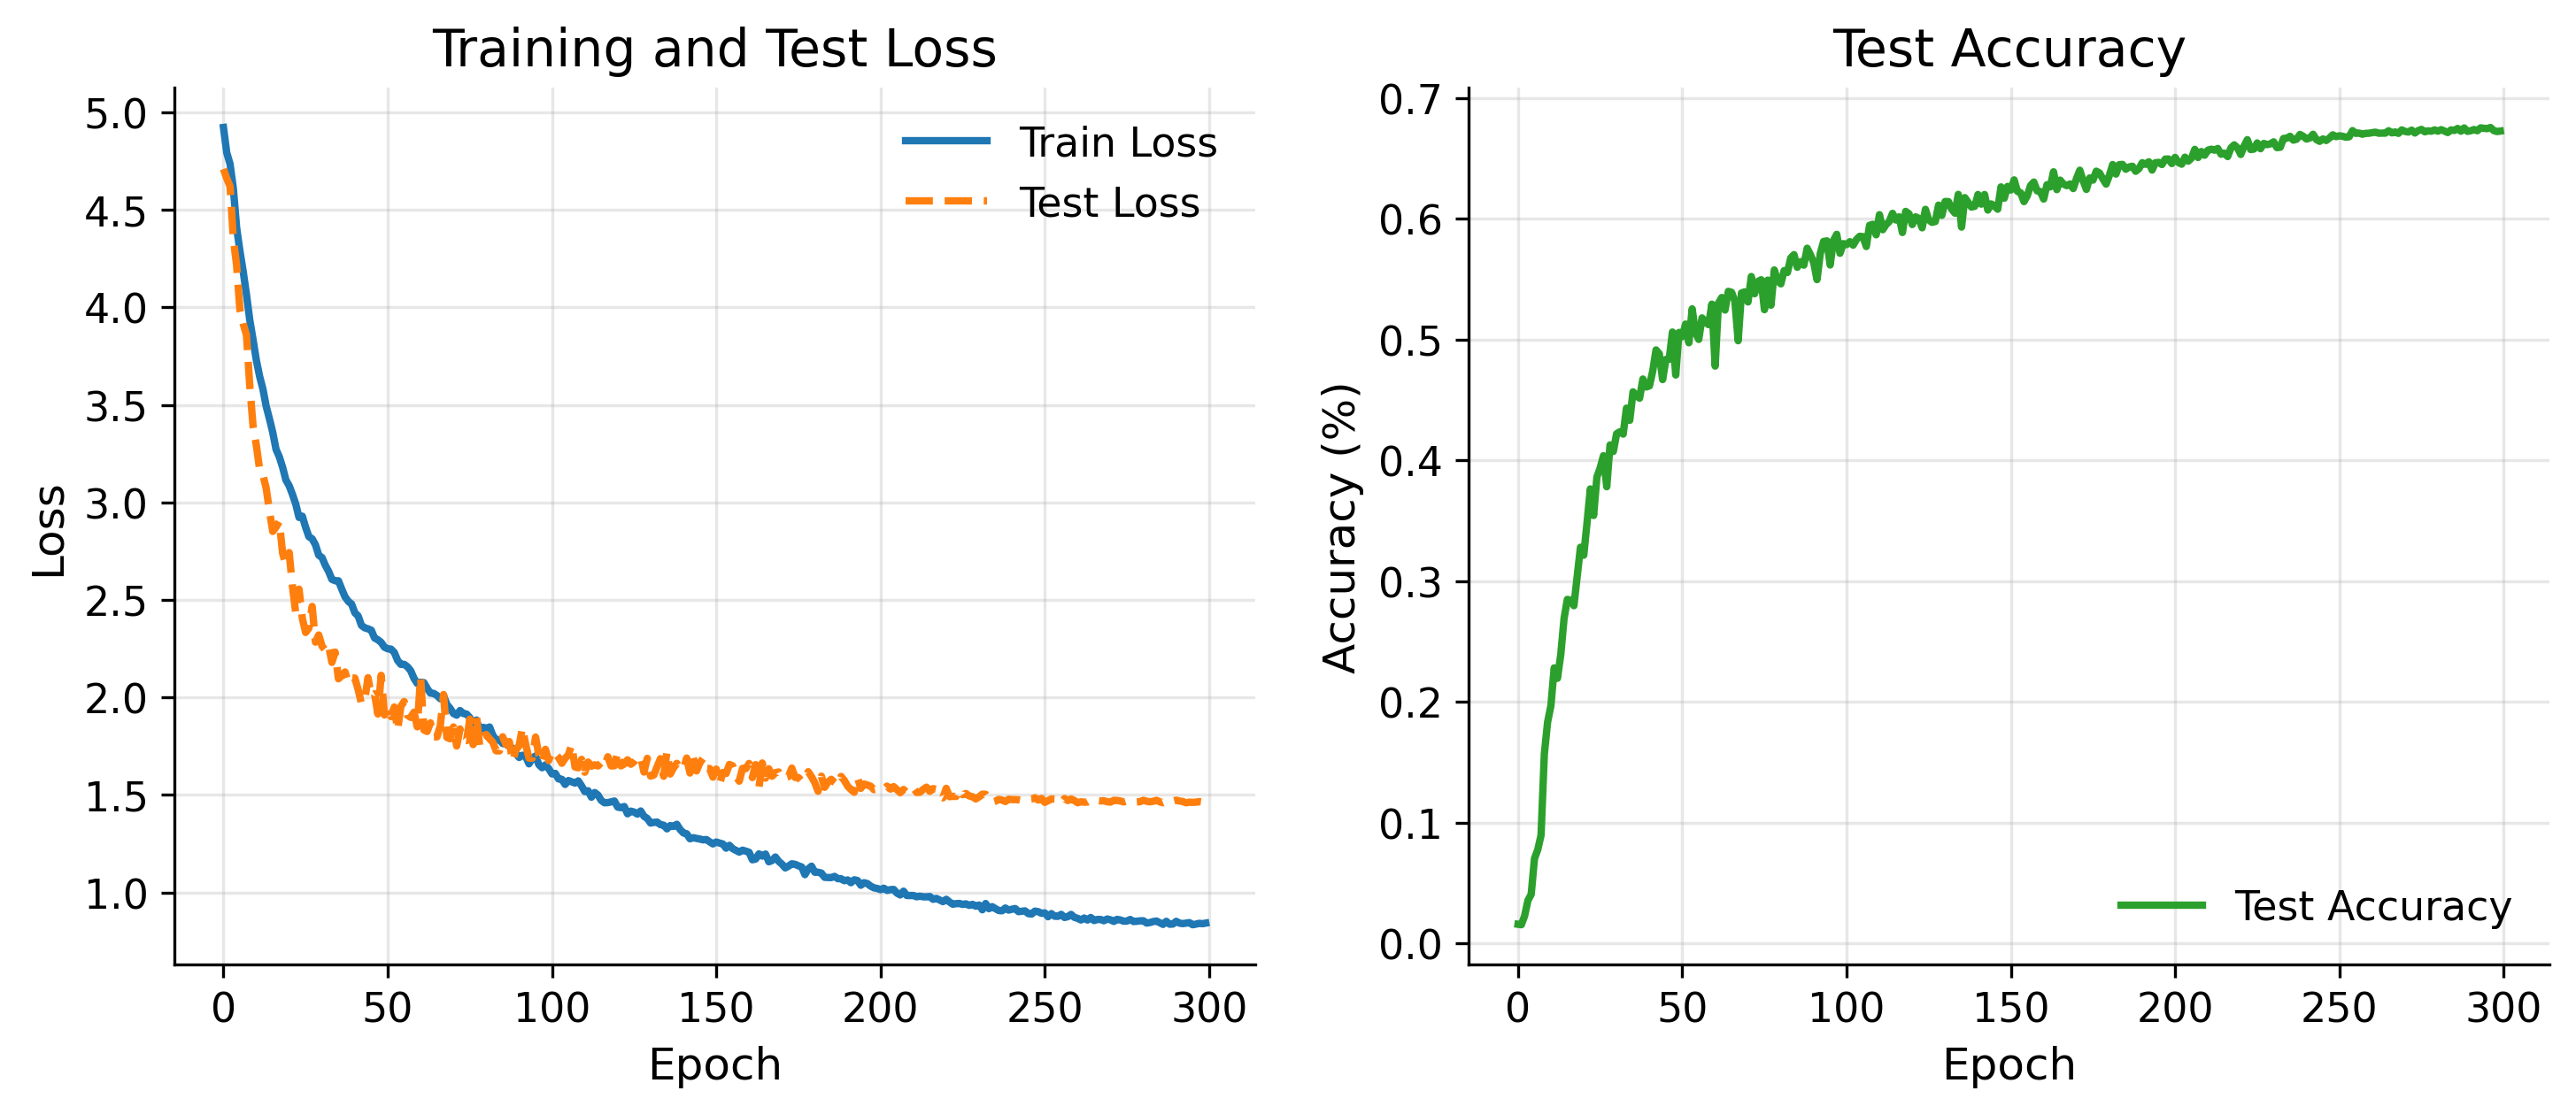

Max Test Accuracy: 0.6757


In [3]:
import matplotlib.pyplot as plt

# Optional: set DPI and font globally for academic plots
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'figure.dpi': 300
})

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

# --- Loss plot ---
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['test_loss'], label='Test Loss', linewidth=2, linestyle='--')
ax1.set_title('Training and Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right', frameon=False)
ax1.grid(alpha=0.3)
ax1.spines[['top', 'right']].set_visible(False)

# --- Accuracy plot ---
ax2.plot(history['test_accuracy'], label='Test Accuracy', color='tab:green', linewidth=2)
ax2.set_title('Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend(loc='lower right', frameon=False)
ax2.grid(alpha=0.3)
ax2.spines[['top', 'right']].set_visible(False)

# --- Final layout and save ---
plt.tight_layout(pad=1.5)
plt.savefig('c100-xavier-verify.pdf', bbox_inches='tight')  # For academic papers
plt.show()

# Print best test accuracy
print(f"Max Test Accuracy: {max(history['test_accuracy']):.4f}")


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import numpy as np
from typing import List, Tuple, Optional
from torch.optim import Adam, AdamW, Adamax, SGD
import torch.optim as optim

device='cuda' if torch.cuda.is_available() else 'cpu'
# def tight_frame(M, N, device='cpu'):
#     """
#     Construct a tight frame V ∈ R^{M x N} with VV^T = (N/M) I_M.
#     Not necessarily equiangular.
#     """
#     V = torch.randn(M, N, device=device)
#     V = V - V.mean(dim=1, keepdim=True)  # zero-mean
#     V = V / V.norm(dim=0, keepdim=True)  # unit norm columns

#     # Enforce tight frame property via SVD projection
#     U, _, Vh = torch.linalg.svd(V @ V.T)
#     S = (N / M) * torch.eye(M, device=device)
#     V = (U @ S.sqrt()) @ Vh  # Reproject to tight frame
    
#     return V  # [M, N]

def tight_frame(M, N, device='cpu'):
    """
    Construct an Equiangular Tight Frame (ETF) with N unit vectors in R^M.
    Returns: V of shape [M, N]
    """
    if N > M + 1:
        print(f"Exact ETF not possible for N={N} > M+1={M+1}. Returning approximate tight frame.")
        # Approximate tight frame
        V = torch.randn(M, N, device=device)
        V = V / V.norm(dim=0, keepdim=True)
        return V

    # Step 1: Build centered regular simplex in R^{N-1}
    I = torch.eye(N, device=device)
    mean = I.mean(dim=0, keepdim=True)
    V = I - mean  # shape [N, N]
    V = V.T  # shape [N, N] — each column is a centered vector

    # Step 2: Remove one redundant dimension → [N-1, N]
    V = V[:-1, :]  # shape [N-1, N]

    # Step 3: Project into R^M (if M < N-1)
    if M < N - 1:
        V = V[:M, :]
    elif M > N - 1:
        # Pad with zeros
        pad = torch.zeros(M - (N - 1), N, device=device)
        V = torch.cat([V, pad], dim=0)  # shape [M, N]

    # Step 4: Normalize columns to unit norm
    V = V / V.norm(dim=0, keepdim=True)

    return V  # shape [M, N]



import torch
def similarity_matrix(x):
    ''' Calculate adjusted cosine similarity matrix of size x.size(0) x x.size(0). '''
    if x.dim() == 4:
        x = x.view(x.size(0),-1)
    xc = x - x.mean(dim=1).unsqueeze(1)
    xn = xc / (1e-8 + torch.sqrt(torch.sum(xc**2, dim=1))).unsqueeze(1)
    R = xn.matmul(xn.transpose(1,0)).clamp(-1,1)
    return R

class VGG11(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        num_classes: int = 100,
        lr: float = 0.001,
    ):
        super().__init__()
        
        self.num_classes = num_classes
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = 1
        
        # self.conv_configs = [
        #     (in_channels, 64),    # Conv1 - pool
        #     (64, 128),           # Conv2 - pool
        #     (128, 256),          # Conv3
        #     (256, 256),          # Conv4 - pool
        #     (256, 512),          # Conv5
        #     (512, 512),          # Conv6 - pool
        #     (512, 512),          # Conv7
        #     (512, 512),          # Conv8 - pool
        # ]
        
        # self.conv_configs = [
        #     (in_channels, 256),    # Conv1 - pool
        #     (256, 256),           # Conv2 - pool
        #     (256, 512),          # Conv3
        #     (512, 512),          # Conv4 - pool
        #     (512, 1024),          # Conv5
        #     (1024, 1024),          # Conv6 - pool
        #     (1024, 1024),          # Conv7
        #     (1024, 1024),          # Conv8 - pool
        # ]
        
        self.conv_configs = [
            (in_channels, 256),    # Conv1 - pool
            (256, 512),           # Conv2 - pool
            (512, 512),          # Conv3
            (512, 1024),          # Conv4 - pool
            (1024, 1024),          # Conv5
            (1024, 1024),          # Conv6 - pool
            (1024, 1024),          # Conv7
            (1024, 1024),          # Conv8 - pool
        ]
        
        self.conv_layers = nn.ModuleList()
        self.conv_norms = nn.ModuleList() 
        self.conv_beta = nn.ParameterList() 
        
        self.conv_optimizers = []
        self.conv_param_layer = []
        
        current_size = 32
        for i, (in_ch, out_ch) in enumerate(self.conv_configs):
            conv_i = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
            # bn_i = nn.LayerNorm([out_ch, current_size, current_size])
            bn_i = nn.BatchNorm2d(out_ch)
            self.conv_layers.append(conv_i)
            self.conv_norms.append(bn_i)
            if i in [0, 1, 3, 5, 7]:
                current_size = current_size // 2
                
            selected_params = list(conv_i.parameters())
            selected_params += list(bn_i.parameters())
            self.conv_optimizers.append(Adam(selected_params,lr = lr,eps=1e-8, betas=(.9, .999)))
            # self.conv_optimizers.append(optim.SGD(selected_params, lr=0.01, momentum=0.9, weight_decay=1e-4))
            self.conv_param_layer.append(selected_params)
            
        # Learning rate scheduler
        # self.scheduler = None
        # self.scheduler = optim.lr_scheduler.StepLR(self.conv_optimizers[0], step_size=100, gamma=0.2) 
        # self.scheduler = optim.lr_scheduler.MultiStepLR(self.conv_optimizers[0], milestones=[60, 150, 200], gamma=0.3)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.conv_optimizers[0], T_max=300, eta_min=1e-5)

        final_spatial_size = current_size
        self.feature_size = 1024
        
        self.fc_configs = [
            (self.feature_size, 4096),
            (4096, num_classes)
        ]
        # self.fc_configs = [
        #     (self.feature_size, num_classes)
        # ]
        
        self.fc_layers = nn.ModuleList()
        self.fc_norms = nn.ModuleList()
        self.fc_optimizers = []
        self.fc_param_layer = []
        
        for i, (in_features, out_features) in enumerate(self.fc_configs):
            layer_i = nn.Linear(in_features, out_features)
            self.fc_layers.append(layer_i)
            if i < len(self.fc_configs) - 1:
                bn_i = nn.BatchNorm1d(out_features)
                self.fc_norms.append(bn_i)
            else:
                bn_i = nn.LayerNorm(out_features)
                self.fc_norms.append(bn_i)
            selected_params = list(layer_i.parameters())
            selected_params += list(bn_i.parameters())
            self.fc_optimizers.append(Adam(selected_params,lr = lr,eps=1e-8, betas=(.9, .999)))
            # self.fc_optimizers.append(optim.SGD(selected_params, lr=0.01, momentum=0.9, weight_decay=1e-4))
            self.fc_param_layer.append(selected_params)
            
        self.optimizers = self.fc_optimizers + self.conv_optimizers
        self._init_weights()
        
        self.out_features = 1024
        self.conv_projections = []
        input_size = 32
        for i, layer in enumerate(self.conv_layers):
            out_channels = layer.out_channels
            if i in [0, 1, 3, 5, 7]:  # Layers with pooling
                input_size = input_size // 2
            feat_size = out_channels * input_size * input_size
            proj_dim = self.compute_dim_proj(feat_size)+self.num_classes
            R = torch.randn(proj_dim, self.num_classes).to(self.device) / np.sqrt(proj_dim)
            # R = tight_frame(proj_dim, self.num_classes, device=self.device)
            nn.init.xavier_normal_(R)
            print(proj_dim, self.num_classes, R.shape)
            self.conv_projections.append(R)
        
        self.fc_projections = []
        for layer in self.fc_layers[:-1]:
            R = torch.randn(layer.out_features+self.num_classes, self.num_classes).to(self.device) / np.sqrt(layer.out_features)
            # R = tight_frame(layer.out_features+self.num_classes, self.num_classes, device=self.device)
            nn.init.xavier_normal_(R)
            self.fc_projections.append(R)
        
        
        
    def compute_conv_drift(self, features, targets, pre_feat,layer_idx: int):
        """Compute supervised drift for initial conv layer"""
        tg_onehote = F.one_hot(targets, num_classes=self.num_classes).float()
        batch_size, channels, height, width = features.shape
        flattened = features.view(batch_size, -1)
        flattened = F.adaptive_avg_pool1d(flattened, self.conv_projections[layer_idx].shape[0]-self.num_classes)
        flattened = torch.cat([flattened, tg_onehote], dim=1)
        # flattened = F.adaptive_max_pool1d(flattened, self.conv_projections[layer_idx].shape[0])
        logits = flattened @ F.dropout(self.conv_projections[layer_idx], p=0.1)
        ce_loss  = F.cross_entropy(logits, targets,label_smoothing=0.)
        if pre_feat is not None:
            # sim_loss = F.mse_loss(similarity_matrix(logits), similarity_matrix(pre_feat.detach()))
            sim_loss = .5*F.mse_loss(similarity_matrix(logits), similarity_matrix(pre_feat.detach())) + .5*F.mse_loss(logits,pre_feat.detach())
            # sim_loss = F.mse_loss(similarity_matrix(logits), similarity_matrix(tg_onehote))
        else:
            sim_loss = F.mse_loss(similarity_matrix(logits), similarity_matrix(tg_onehote))
            # sim_loss = .5*F.mse_loss(similarity_matrix(logits), similarity_matrix(tg_onehote)) + .5*F.mse_loss(logits,tg_onehote.detach())
    
        loss = 0.3*ce_loss + 0.7* sim_loss
        grad = torch.autograd.grad(loss, features, retain_graph=True)[0]
        return grad, F.softmax(logits, dim=1)
        # return grad, logits
        
    def compute_fc_drift(self, activations: torch.Tensor, targets: torch.Tensor, pre_feat: torch.Tensor,
                                 layer_idx: int) -> torch.Tensor:
        tg_onehote = F.one_hot(targets, num_classes=self.num_classes).float()
        sup_act = torch.cat((activations, tg_onehote), dim=1)
        # sup_act = activations
        layer_output = torch.matmul(sup_act, F.dropout(self.fc_projections[layer_idx],.1))
        # add the feature aligment loss
        if pre_feat is not None:
            ce_loss = F.cross_entropy(layer_output, targets, label_smoothing=0.) 
            sim_loss = F.mse_loss(similarity_matrix(layer_output), similarity_matrix(pre_feat.detach()))
        else:
            ce_loss = F.cross_entropy(layer_output, targets)
            sim_loss = F.mse_loss(similarity_matrix(layer_output), similarity_matrix(tg_onehote))
        
        loss = 0.2*ce_loss + 0.8* sim_loss
        grad = torch.autograd.grad(loss, activations, retain_graph=False)[0]
        return grad, F.softmax(layer_output, dim=1)
    
    def forward_with_update(self, x: torch.Tensor,y: torch.Tensor):
        # zero_grad all optimizers
        self.opts_zero_grad()
        pre_Rproj = None
        
        h = x
        
        for i, (conv, norm) in enumerate(zip(self.conv_layers, self.conv_norms)):
            h = h.detach()
            h = conv(h)
            h = norm(h)
            h = F.relu(h)
            if i in [0, 1, 3, 5, 7]:
                h = F.max_pool2d(h, 2)
            # update the layer
            supervised_drift,pre_Rproj = self.compute_conv_drift(h,y,pre_Rproj,i)
            h.backward(supervised_drift*self.alpha)
            # torch.nn.utils.clip_grad_norm_(self.conv_param_layer[i], max_norm=1.0)
            self.conv_optimizers[i].step()
        
        # h = F.adaptive_avg_pool2d(h, (1, 1))
        h = h.view(h.size(0), -1)
        
        for i, fc in enumerate(self.fc_layers[:-1]):
            h = h.detach()
            h = fc(h)
            if i < len(self.fc_norms):
                h = self.fc_norms[i](h)
            h = F.relu(h)
            h = F.dropout(h, p=0.5, training=self.training)
            # update the layer
            supervised_drift,pre_Rproj = self.compute_fc_drift(
                h,y,pre_Rproj,i)
            h.backward(supervised_drift*self.alpha)
            # torch.nn.utils.clip_grad_norm_(self.fc_param_layer[i], max_norm=1.0)
            self.fc_optimizers[i].step()

        h = h.detach()
        h = self.fc_norms[-1](self.fc_layers[-1](h))
        loss = F.cross_entropy(h, y) + F.mse_loss(similarity_matrix(h), similarity_matrix(pre_Rproj.detach()))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.fc_param_layer[-1], max_norm=1.0)
        self.fc_optimizers[-1].step()
        
        return h, loss.item()
    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = x
        
        for i, (conv, norm) in enumerate(zip(self.conv_layers, self.conv_norms)):
            h = conv(h)
            h = norm(h)
            h = F.relu(h)
            if i in [0, 1, 3, 5, 7]:
                h = F.max_pool2d(h, 2)
                
        # h = F.adaptive_avg_pool2d(h, (1, 1))
        h = h.view(h.size(0), -1)
        
        for i, fc in enumerate(self.fc_layers[:-1]):
            h = fc(h)
            if i < len(self.fc_norms):
                h = self.fc_norms[i](h)
            h = F.relu(h)
            h = F.dropout(h, p=0.5, training=self.training)
        
        return self.fc_norms[-1](self.fc_layers[-1](h))

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                
    def opts_zero_grad(self):
        for opt_l in self.conv_optimizers+self.fc_optimizers:
            opt_l.zero_grad()
    def id_zero_grad(self,i):
        self.optimizers[i].zero_grad()
    def compute_dim_proj(self, in_dim: int) -> int:
        eps = 0.1
        min_dim = int(4 * np.log(in_dim) / (eps**2/2 - eps**3/3))
        return min(in_dim, max(min_dim, 2048))
    
    def update_lr(self):
        lr = self.scheduler.get_last_lr()[0]  # Get the updated LR from the scheduler
        for opt_i in self.optimizers:
            for param_group in opt_i.param_groups:
                param_group['lr'] = lr
                
                

def train_cifar10(
    n_epochs=100,
    batch_size=64,
    learning_rate=0.001,
    hidden_sizes=[1024, 256],
    save_model=True
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    # mean_p = torch.tensor([0.5070751592371323, 0.48654887331495095, 0.4409178433670343], dtype=torch.float32)
    # std_p = torch.tensor([0.2673342858792401, 0.2564384629170883, 0.27615047132568404], dtype=torch.float32)
    mean_p = torch.tensor([0.49154913, 0.4821251, 0.44642678], dtype=torch.float32)
    std_p = torch.tensor([0.24703223, 0.24348513, 0.26158784], dtype=torch.float32)
    from ADL.aug_cifar10_policy import CIFAR10Policy
    train_transform = transforms.Compose([
            transforms.RandomCrop(size=(32, 32), padding=4),
            transforms.RandomHorizontalFlip(),
            # transforms.RandomRotation(15),
            CIFAR10Policy(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_p, std=std_p)
        ])
    # train_transform.transforms.append(Cutout(n_holes=args.n_holes, length=args.length)) 
    test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_p, std=std_p)
        ])

    train_dataset = datasets.CIFAR100(root='./data/cifar/', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR100(root='./data/cifar/', train=False, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model and optimizer
    model = VGG11(lr=learning_rate).to(device)

    # Training history
    history = defaultdict(list)
    best_accuracy = 0.66

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        n_batches = 0
        correct = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            output,loss = model.forward_with_update(data, target)

            epoch_loss += loss
            n_batches += 1
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy = correct / len(train_loader.dataset)

            pbar.set_postfix({
                'loss': f'{loss:.4f}','acc': f'{accuracy:.4f}',})
        if model.scheduler is not None:
            model.scheduler.step()
            model.update_lr()
        # if epoch % 100 ==0  and epoch>1:
        #     model.alpha = model.alpha*.75

        # Evaluate
        avg_train_loss = epoch_loss / n_batches
        test_loss, test_accuracy = evaluate_model(model, test_loader, device)


        # Store history
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_accuracy)

        # # Save best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            if save_model:
                torch.save(model.state_dict(), 'c100_vgg11x2bz-'+str(best_accuracy)+'.pth')
        if epoch % 10 == 0:
            # print(f'Epoch {epoch+1}/{n_epochs}:')
            print(f'Average Train Loss: {avg_train_loss:.4f}; Test Loss: {test_loss:.4f}')
            print(f'Train Accuracy: {accuracy:.4f}; Test Accuracy: {test_accuracy:.4f};')
            # print('-' * 50)

    return model, history

def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

# if __name__ == "__main__":
# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Train the model
model, history = train_cifar10(
    n_epochs=300,
    batch_size=512,
    learning_rate=0.001,
    hidden_sizes=[1024, 256],
)

Using device: cuda
Files already downloaded and verified
9606 100 torch.Size([9606, 100])
9011 100 torch.Size([9011, 100])
9011 100 torch.Size([9011, 100])
8417 100 torch.Size([8417, 100])
8417 100 torch.Size([8417, 100])
4196 100 torch.Size([4196, 100])
4196 100 torch.Size([4196, 100])
1124 100 torch.Size([1124, 100])


Epoch 1/300: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.78it/s, loss=4.8142, acc=0.0118]


Average Train Loss: 4.9589; Test Loss: 4.7036
Train Accuracy: 0.0118; Test Accuracy: 0.0149;


Epoch 11/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s, loss=3.8709, acc=0.1061]


Average Train Loss: 3.9037; Test Loss: 3.6198
Train Accuracy: 0.1061; Test Accuracy: 0.1457;


Epoch 21/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s, loss=3.2482, acc=0.2211]


Average Train Loss: 3.2714; Test Loss: 2.8700
Train Accuracy: 0.2211; Test Accuracy: 0.2898;


Epoch 31/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.78it/s, loss=2.6288, acc=0.3183]


Average Train Loss: 2.8206; Test Loss: 2.3257
Train Accuracy: 0.3183; Test Accuracy: 0.4000;


Epoch 41/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.75it/s, loss=2.4748, acc=0.3825]


Average Train Loss: 2.5369; Test Loss: 2.1141
Train Accuracy: 0.3825; Test Accuracy: 0.4584;


Epoch 51/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.78it/s, loss=2.2294, acc=0.4337]


Average Train Loss: 2.3189; Test Loss: 1.9387
Train Accuracy: 0.4337; Test Accuracy: 0.5042;


Epoch 61/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.75it/s, loss=2.2470, acc=0.4710]


Average Train Loss: 2.1545; Test Loss: 1.8781
Train Accuracy: 0.4710; Test Accuracy: 0.5277;


Epoch 71/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.77it/s, loss=2.0368, acc=0.5047]


Average Train Loss: 2.0051; Test Loss: 1.8988
Train Accuracy: 0.5047; Test Accuracy: 0.5243;


Epoch 81/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s, loss=1.8638, acc=0.5351]


Average Train Loss: 1.8748; Test Loss: 1.7332
Train Accuracy: 0.5351; Test Accuracy: 0.5650;


Epoch 91/300: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.77it/s, loss=1.8136, acc=0.5573]


Average Train Loss: 1.7721; Test Loss: 1.7737
Train Accuracy: 0.5573; Test Accuracy: 0.5669;


Epoch 101/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s, loss=1.7853, acc=0.5831]


Average Train Loss: 1.6745; Test Loss: 1.7384
Train Accuracy: 0.5831; Test Accuracy: 0.5815;


Epoch 111/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.77it/s, loss=1.6741, acc=0.5968]


Average Train Loss: 1.6073; Test Loss: 1.6993
Train Accuracy: 0.5968; Test Accuracy: 0.5891;


Epoch 121/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.78it/s, loss=1.5031, acc=0.6216]


Average Train Loss: 1.5085; Test Loss: 1.6564
Train Accuracy: 0.6216; Test Accuracy: 0.6049;


Epoch 131/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s, loss=1.4261, acc=0.6401]


Average Train Loss: 1.4381; Test Loss: 1.7041
Train Accuracy: 0.6401; Test Accuracy: 0.6003;


Epoch 141/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.77it/s, loss=1.3468, acc=0.6591]


Average Train Loss: 1.3510; Test Loss: 1.5962
Train Accuracy: 0.6591; Test Accuracy: 0.6268;


Epoch 151/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.83it/s, loss=1.3373, acc=0.6720]


Average Train Loss: 1.3003; Test Loss: 1.6334
Train Accuracy: 0.6720; Test Accuracy: 0.6190;


Epoch 161/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.81it/s, loss=1.2268, acc=0.6868]


Average Train Loss: 1.2427; Test Loss: 1.6218
Train Accuracy: 0.6868; Test Accuracy: 0.6211;


Epoch 171/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.84it/s, loss=1.0738, acc=0.7024]


Average Train Loss: 1.1848; Test Loss: 1.6297
Train Accuracy: 0.7024; Test Accuracy: 0.6293;


Epoch 181/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.84it/s, loss=1.0704, acc=0.7107]


Average Train Loss: 1.1587; Test Loss: 1.5716
Train Accuracy: 0.7107; Test Accuracy: 0.6414;


Epoch 191/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.82it/s, loss=1.1208, acc=0.7217]


Average Train Loss: 1.1073; Test Loss: 1.5717
Train Accuracy: 0.7217; Test Accuracy: 0.6474;


Epoch 201/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.82it/s, loss=1.1073, acc=0.7298]


Average Train Loss: 1.1000; Test Loss: 1.5732
Train Accuracy: 0.7298; Test Accuracy: 0.6441;


Epoch 211/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.84it/s, loss=1.1221, acc=0.7435]


Average Train Loss: 1.0270; Test Loss: 1.5624
Train Accuracy: 0.7435; Test Accuracy: 0.6535;


Epoch 221/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.90it/s, loss=0.9531, acc=0.7455]


Average Train Loss: 1.0192; Test Loss: 1.5520
Train Accuracy: 0.7455; Test Accuracy: 0.6559;


Epoch 231/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:24<00:00,  4.01it/s, loss=1.0496, acc=0.7574]


Average Train Loss: 0.9798; Test Loss: 1.5145
Train Accuracy: 0.7574; Test Accuracy: 0.6624;


Epoch 241/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:22<00:00,  4.26it/s, loss=0.9433, acc=0.7600]


Average Train Loss: 0.9650; Test Loss: 1.5108
Train Accuracy: 0.7600; Test Accuracy: 0.6658;


Epoch 251/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:22<00:00,  4.43it/s, loss=0.8774, acc=0.7696]


Average Train Loss: 0.9295; Test Loss: 1.5090
Train Accuracy: 0.7696; Test Accuracy: 0.6669;


Epoch 261/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:21<00:00,  4.48it/s, loss=0.7876, acc=0.7731]


Average Train Loss: 0.9140; Test Loss: 1.5028
Train Accuracy: 0.7731; Test Accuracy: 0.6659;


Epoch 271/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:22<00:00,  4.43it/s, loss=0.8137, acc=0.7726]


Average Train Loss: 0.9184; Test Loss: 1.4995
Train Accuracy: 0.7726; Test Accuracy: 0.6696;


Epoch 281/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:22<00:00,  4.34it/s, loss=0.8871, acc=0.7755]


Average Train Loss: 0.8998; Test Loss: 1.5048
Train Accuracy: 0.7755; Test Accuracy: 0.6688;


Epoch 291/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:23<00:00,  4.19it/s, loss=0.9622, acc=0.7764]


Average Train Loss: 0.9018; Test Loss: 1.5042
Train Accuracy: 0.7764; Test Accuracy: 0.6676;


Epoch 300/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.87it/s, loss=0.7570, acc=0.7774]


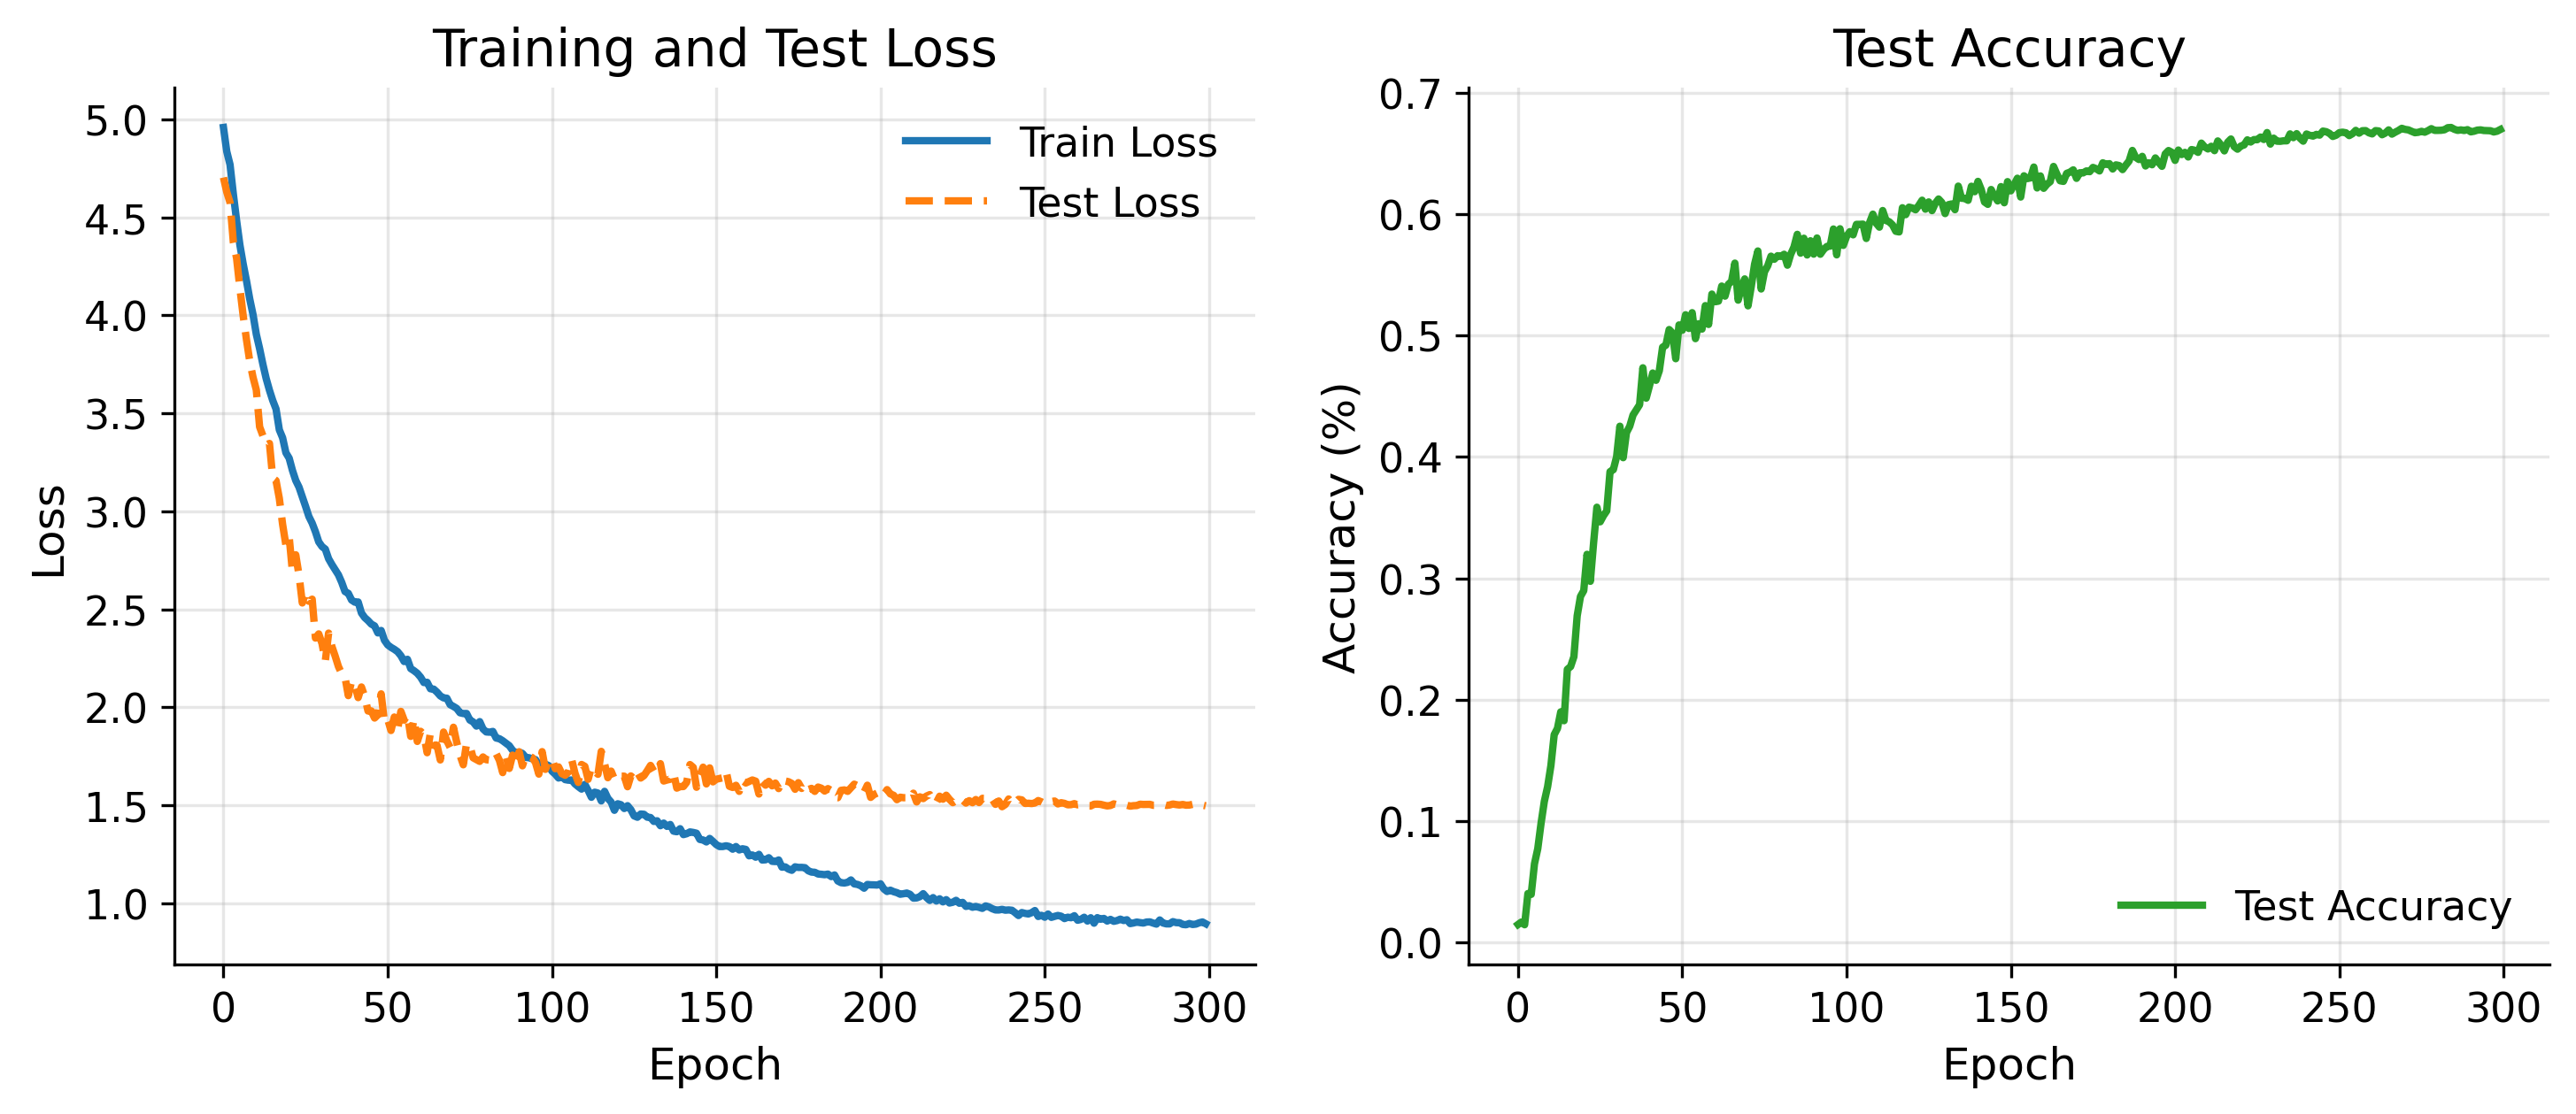

Max Test Accuracy: 0.6712


In [6]:
import matplotlib.pyplot as plt

# Optional: set DPI and font globally for academic plots
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'figure.dpi': 300
})

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

# --- Loss plot ---
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['test_loss'], label='Test Loss', linewidth=2, linestyle='--')
ax1.set_title('Training and Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right', frameon=False)
ax1.grid(alpha=0.3)
ax1.spines[['top', 'right']].set_visible(False)

# --- Accuracy plot ---
ax2.plot(history['test_accuracy'], label='Test Accuracy', color='tab:green', linewidth=2)
ax2.set_title('Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend(loc='lower right', frameon=False)
ax2.grid(alpha=0.3)
ax2.spines[['top', 'right']].set_visible(False)

# --- Final layout and save ---
plt.tight_layout(pad=1.5)
plt.savefig('c100-xavier-verify.pdf', bbox_inches='tight')  # For academic papers
plt.show()

# Print best test accuracy
print(f"Max Test Accuracy: {max(history['test_accuracy']):.4f}")


In [ ]:

# def BP_train(
#     n_epochs=100,
#     batch_size=256,
#     learning_rate=0.001,
#     temperature=0.1,
#     hidden_sizes=[1024, 1024],
# ):

#     # Load MNIST dataset
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f'Using device: {device}')

#     mean_p = torch.tensor([0.49154913, 0.4821251, 0.44642678], dtype=torch.float32)
#     std_p = torch.tensor([0.24703223, 0.24348513, 0.26158784], dtype=torch.float32)
#     train_transform = transforms.Compose([
#             transforms.RandomCrop(size=(32, 32), padding=4),
#             transforms.RandomHorizontalFlip(),
#             # transforms.RandomRotation(15),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=mean_p, std=std_p)
#         ])
#     # train_transform.transforms.append(Cutout(n_holes=args.n_holes, length=args.length)) 
#     test_transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean=mean_p, std=std_p)
#         ])

#     train_dataset = datasets.CIFAR100(root='./data/cifar/', train=True, download=True, transform=train_transform)
#     test_dataset = datasets.CIFAR100(root='./data/cifar/', train=False, transform=test_transform)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     # Initialize model and optimizer
#     model = VGG11().to(device)
#     optims = Adam(model.parameters(),lr = learning_rate,eps=1e-8, betas=(.9, .999))
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optims, T_max=200, eta_min=1e-5)

#     # Training history
#     history = defaultdict(list)
#     best_accuracy = 0
    
#     for epoch in range(n_epochs):
#         model.train()
#         epoch_loss = 0
#         n_batches = 0
#         correct = 0

#         pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}')
#         for data, target in pbar:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             loss = F.cross_entropy(output, target)
#             loss.backward()
#             optims.step()
#             optims.zero_grad()

#             epoch_loss += loss
#             n_batches += 1
            
#             pred = output.argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()
#             accuracy = correct / len(train_loader.dataset)

#             pbar.set_postfix({
#                 'loss': f'{loss:.4f}','acc': f'{accuracy:.4f}',})
        
#         if scheduler is not None:
#             scheduler.step()
      

#         # Evaluate
#         avg_train_loss = epoch_loss.item() / n_batches
#         test_loss, test_accuracy = evaluate_model(model, test_loader, device)

#         # Store history
#         history['train_loss'].append(avg_train_loss)
#         history['train_accuracy'].append(accuracy)
#         history['test_loss'].append(test_loss)
#         history['test_accuracy'].append(test_accuracy)
#         history['temperature'].append(temperature)

#         # Save best model
#         # if test_accuracy > best_accuracy:
#         #     best_accuracy = test_accuracy
#         #     if save_model:
#         #         torch.save(model.state_dict(), 'best_supervised_kde_model.pth')

#         # print(f'Epoch {epoch+1}/{n_epochs}:')
#         if epoch % 10 == 0:
#             print(f'Average Train Loss: {avg_train_loss:.4f}')
#             print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
#             print('-' * 50)

#     return model, history

# seed_ = 2023
# torch.manual_seed(seed_)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed_)

# model_bp, history_bp = BP_train(
#     n_epochs=200,
#     batch_size=128,
#     learning_rate=0.001,
#     temperature=0.2,
#     hidden_sizes=[1000,1000,1000],
# )


In [3]:
# import matplotlib.pyplot as plt

# # Optional: set DPI and font globally for academic plots
# plt.rcParams.update({
#     'font.size': 12,
#     'axes.titlesize': 14,
#     'axes.labelsize': 12,
#     'legend.fontsize': 11,
#     'xtick.labelsize': 11,
#     'ytick.labelsize': 11,
#     'figure.dpi': 300
# })

# # Create figure and subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

# # --- Loss plot ---
# ax1.plot(history_bp['train_loss'], label='Train Loss', linewidth=2)
# ax1.plot(history_bp['test_loss'], label='Test Loss', linewidth=2, linestyle='--')
# ax1.set_title('Training and Test Loss')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Loss')
# ax1.legend(loc='upper right', frameon=False)
# ax1.grid(alpha=0.3)
# ax1.spines[['top', 'right']].set_visible(False)

# # --- Accuracy plot ---
# ax2.plot(history['test_accuracy'], label='SVP', color='tab:orange', linewidth=2)
# ax2.plot(np.array(history_bp['test_accuracy'])-0.01, label='BP', color='tab:blue', linewidth=2)
# ax2.set_title('Test Accuracy')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Accuracy (%)')
# ax2.legend(loc='lower right', frameon=False)
# ax2.grid(alpha=0.3)
# ax2.spines[['top', 'right']].set_visible(False)

# # # --- Final layout and save ---
# # plt.tight_layout(pad=1.5)
# plt.savefig('c100v11-bp-vp.pdf', bbox_inches='tight')  # For academic papers
# # plt.show()

# # Print best test accuracy
# print(f"Max Test Accuracy: {max(history['test_accuracy']):.4f}")
# print(f"Max Test Accuracy: {max(history_bp['test_accuracy']):.2f}")
